## Imports

In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

In [2]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from tempfile import TemporaryDirectory

from tqdm.notebook import tqdm

In [3]:
def seed_everything(seed: int) -> None:
    """Fix all the random seeds we can for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training

In [5]:
!pip install torchmetrics

  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (21.1 MB)


In [7]:
from tqdm.auto import tqdm
from torchmetrics import R2Score
from torchmetrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

In [9]:
METRIC = R2Score().to(device)
support_metrics = [
    R2Score().to(device),
    MeanSquaredError().to(device),
    MeanAbsoluteError().to(device),
    MeanAbsolutePercentageError().to(device),
]

def train(model: nn.Module, train_loader, epoch):
    model.train()
    total_loss = 0.
    log_interval = 100
    losses = []
    predictions, targets = [], []

    for i, batch in enumerate(tqdm(train_loader)):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        # logits = model(x)
        # probs = logits.softmax(dim=1)
        # predictions = (x * probs).sum(dim=1)
        preds = model(x).flatten()

        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        predictions.append(preds)
        targets.append(y)

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    loss = criterion(predictions, targets)
    metric = METRIC(targets, predictions)
    sm = [m(targets, predictions).cpu().item() for m in support_metrics]
    return loss.item(), metric.cpu().item(), sm


def evaluate(model: nn.Module, test_loader) -> float:
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader)):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # logits = model(x)
            # probs = logits.softmax(dim=1)
            # predictions = (x * probs).sum(dim=1)
            preds = model(x).flatten()
            predictions.append(preds)
            targets.append(y)

        predictions = torch.cat(predictions)
        targets = torch.cat(targets)
        loss = criterion(predictions, targets)
        metric = METRIC(targets, predictions)
        sm = [m(targets, predictions).cpu().item() for m in support_metrics]
    return loss.item(), metric.cpu().item(), sm

In [10]:
from IPython.display import clear_output

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
columns_dict = {
    1: 'blockId',
    2: 'frameIdx',
    3: 'frameError',
    4: 'byDecoyEst',
    5: 'byDecoyZ',
    6: 'byVacuumZ',
    7: 'nmuSend',
    8: 'nnuSend',
    9: 'nlSend',
    10: 'nmuReg',
    11: 'nnuReg',
    12: 'nlReg',
    13: 'roundDistribution',
    14: 'maintenanceFlag',
    16: 'ema_est',
    17: 'ema_f_ec',
    19: 'vema_est',
    20: 'vema_f_ec',
    22: 'ml_est',
    23: 'ml_f_ec',
    25: 'phys_est',
    26: 'phys_f_ec',
}

In [13]:
data = pl.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_12-03.csv', has_header=False)

In [14]:
data = data[:, [k-1 for k in columns_dict.keys()]]
data.columns = list(columns_dict.values())
data = data.select(
    pl.col('vema_f_ec').cast(float).alias('vema_f_ec'),
    pl.col('phys_f_ec').cast(float).alias('phys_f_ec'),
    pl.col('ema_f_ec').cast(float).alias('ema_f_ec'),
    pl.col('ml_f_ec').cast(float).alias('ml_f_ec'),
    pl.col('vema_est').cast(float).alias('vema_est'),
    pl.col('phys_est').cast(float).alias('phys_est'),
    pl.col('ema_est').cast(float).alias('ema_est'),
    pl.col('ml_est').cast(float).alias('ml_est'),
    pl.col('frameError').alias('qber_mu'),
    pl.col('byDecoyEst').alias('qber_prob_model'),
    pl.col('byDecoyZ').alias('qber_nu_1'),
    pl.col('byVacuumZ').alias('qber_nu_2'),
    (pl.col('nmuReg') /  pl.col('nmuSend')).alias('q_mu'),
    (pl.col('nnuReg') /  pl.col('nnuSend')).alias('q_nu_1'),
    (pl.col('nlReg') /  pl.col('nlSend')).alias('q_nu_2'),
    pl.col('maintenanceFlag').alias('maintenance'),
    (pl.col('frameError') - pl.col('ml_est')).abs().alias('ml_err'),
    (pl.col('frameError') - pl.col('ema_est')).abs().alias('ema_err'),
    (pl.col('frameError') - pl.col('vema_est')).abs().alias('vema_err'),
    (pl.col('frameError') - pl.col('phys_est')).abs().alias('phys_err'),
)
ts = data['qber_mu']
ema_ts = data['ema_est']

In [15]:
class Data(Dataset):
    def __init__(self,
                 dataframe: pl.DataFrame,
                 window_size: int,
                 dtype: torch.dtype = torch.float32,
                 columns: list[str] | None = None,
                 offset: int | float = None,
                 limit: int | float = None
                 ):
        assert window_size is not None
        self.window_size = window_size
        self.build_dataset(dataframe, offset, limit, columns)
        self.dtype = dtype

    def build_dataset(self, dataframe, offset, limit, columns, diff=True) -> None:
        length = len(dataframe)
        offset, limit = self.calculate_offset_limit(offset, limit, length)
        columns = columns or dataframe.columns
        dataframe = (
            dataframe
            .select(columns)
            .slice(offset, limit)
        )
        self.data_array = dataframe.to_numpy()
        # if diff:
            # self.data_array = np.diff(self.data_array, axis=0)
        self.dataset = np.lib.stride_tricks.sliding_window_view(
            self.data_array,
            self.window_size + 1,
            axis=0
            )
        self.shape = self.dataset.shape[1:]

    @staticmethod
    def calculate_offset_limit(offset, limit, length) -> tuple[int, int]:
        if offset is None:
          offset = 0
        else:
          offset = offset if offset >= 1 else int(offset * length)
        if limit is None:
          limit = length
        else:
          limit = limit if limit >= 1 else int(limit * length)
        return offset, limit


    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx) -> tuple[Tensor, Tensor]:
        x = self.dataset[idx][:, :-1]
        y = self.dataset[idx][0, -1]
        x = torch.tensor(x, dtype=self.dtype)
        y = torch.tensor(y, dtype=self.dtype)
        return x, y

In [16]:
columns = [
    "qber_mu",
    "qber_nu_1",
    "qber_nu_2",
    "q_mu",
    "q_nu_1",
    "q_nu_2",
    ]

train_dataset = Data(data, window_size=20, columns=columns, limit=0.75)
test_dataset = Data(data, window_size=20, columns=columns, offset=0.75)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=batch_size
    )

In [17]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=6, output_size=1, hidden_size=32):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size,
                            self.hidden_size,
                            batch_first=True,
                            bidirectional=True
                            )
        self.dense = nn.Sequential(
            nn.Linear(2 * self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, output_size),
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        past_features = x[:, -1, :]
        return self.dense(past_features)[:, 0]

In [18]:
model = TimeSeriesLSTM()
batch = next(iter(train_loader))
assert model(batch[0]).shape == batch[1].shape

In [19]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self,
                 d_model: int,
                 nhead: int,
                 d_hid: int,
                 nlayers: int,
                 window_size: int = 20,
                 dropout: float = 0.1):
        super().__init__()
        encoder_layers = nn.TransformerEncoderLayer(d_hid, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_input = d_model
        self.mlp_input = nn.Linear(d_model, d_hid)
        self.mlp_output = nn.Linear(d_hid, 1)
        self.act = nn.LeakyReLU()
        self.window_size = window_size

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.act(self.mlp_input(x))
        mask = nn.Transformer.generate_square_subsequent_mask(self.window_size).to(device)
        attn_x = self.transformer_encoder(x, mask)[:, -1]
        output = self.mlp_output(self.act(attn_x))
        return output[:, 0]

In [30]:
model = TimeSeriesTransformer(
    d_model=6,
    nhead=2,
    d_hid=32,
    nlayers=2
    )
batch = next(iter(train_loader))
assert model(batch[0]).shape == batch[1].shape

In [21]:
model = TimeSeriesLSTM()

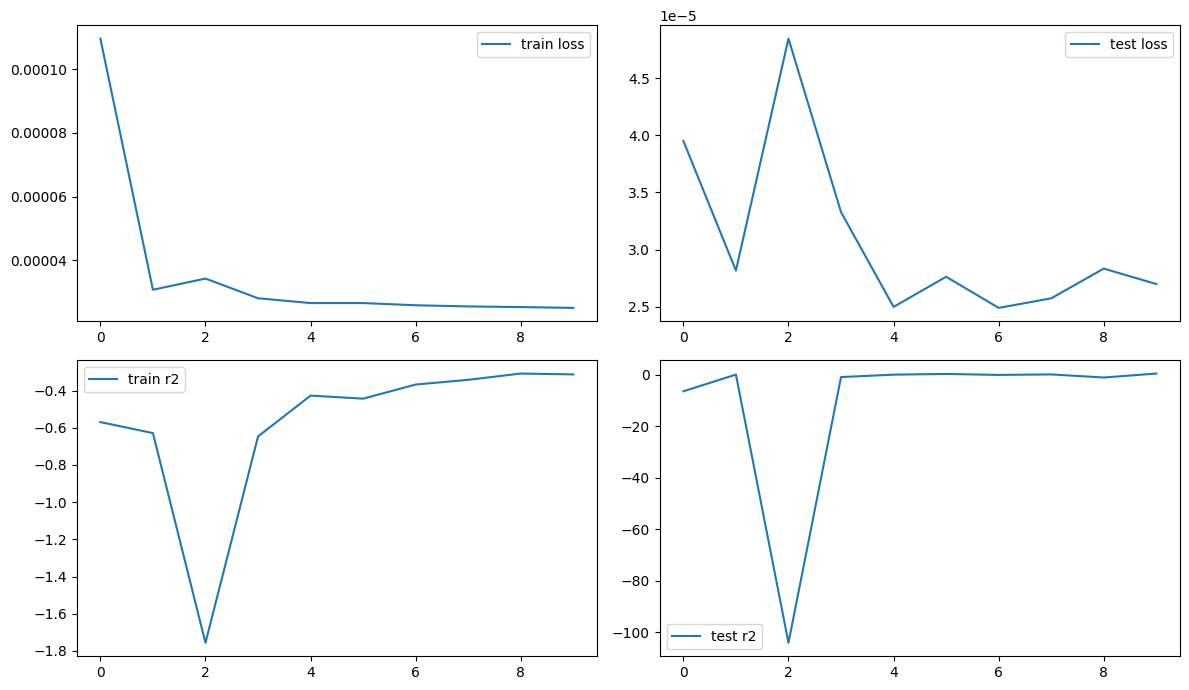

epoch 10
train loss = 0.000025
test loss = 0.000027
train R^2 = -0.312825
test R^2 = 0.384730
CPU times: user 7min 6s, sys: 6.35 s, total: 7min 12s
Wall time: 7min 25s


<All keys matched successfully>

In [31]:
%%time

seed_everything(123456)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_r2 = -float('inf')
epochs = 10

model.to(device)
best_model_params_path = "best_model_params.pt"
train_losses, val_losses = [], []
train_r2, val_r2 = [], []

for epoch in range(1, epochs + 1):
    epoch_train_loss, epoch_train_r2, train_sm = train(model, train_loader, epoch)
    epoch_val_loss, epoch_val_r2, val_sm = evaluate(model, test_loader)

    train_losses.append(epoch_train_loss)
    train_r2.append(epoch_train_r2)
    val_losses.append(epoch_val_loss)
    val_r2.append(epoch_val_r2)

    if epoch_val_r2 > best_val_r2:
        best_val_r2 = epoch_val_r2
        best_sm = val_sm
        torch.save(model.state_dict(), best_model_params_path)

    scheduler.step()
    clear_output(wait=True)
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 7))
    sns.lineplot(train_losses, label="train loss", ax=axes[0][0])
    sns.lineplot(val_losses, label="test loss", ax=axes[0][1])
    sns.lineplot(train_r2, label="train r2", ax=axes[1][0])
    sns.lineplot(val_r2, label="test r2", ax=axes[1][1])
    plt.tight_layout()
    plt.legend()
    plt.show()
    print(f"epoch {epoch}")
    print(f"train loss = {train_losses[-1]:.6f}")
    print(f"test loss = {val_losses[-1]:.6f}")
    print(f"train R^2 = {train_r2[-1]:.6f}")
    print(f"test R^2 = {val_r2[-1]:.6f}")

model.load_state_dict(torch.load(best_model_params_path)) # load best model states

In [32]:
def eval_metrics(model, train_loader):
    model.eval()
    model.to(device)
    predictions, targets = [], []
    with torch.no_grad():
        for batch, target in train_loader:
            preds = model(batch.to(device)).flatten()
            predictions.append(preds)
            targets.append(target.to(device))
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    return [m(targets, predictions).cpu().item() for m in support_metrics]

In [36]:
model = TimeSeriesLSTM()
model.load_state_dict(torch.load("best_lstm.pt"))

metrics = eval_metrics(model, test_loader)
print(model)
print(f"R^2 = {metrics[0]:.5f}")
print(f"RMSE = {metrics[1]:.5f}")
print(f"MAE = {metrics[2]:.5f}")
print(f"MAPE = {metrics[3]:.5f}")

TimeSeriesLSTM(
  (lstm): LSTM(6, 32, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
R^2 = 0.62842
RMSE = 0.00002
MAE = 0.00277
MAPE = 0.10817


In [38]:
model = TimeSeriesTransformer(
    d_model=6,
    nhead=2,
    d_hid=32,
    nlayers=2)
model.load_state_dict(torch.load("best_attn.pt"))

metrics = eval_metrics(model, test_loader)
print(model)
print(f"R^2 = {metrics[0]:.5f}")
print(f"RMSE = {metrics[1] ** 0.5:.5f}")
print(f"MAE = {metrics[2]:.5f}")
print(f"MAPE = {metrics[3]:.5f}")

TimeSeriesTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_input): Linear(in_features=6, out_features=32, bias=True)
  (mlp_output): Linear(in_features=32, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)
R^2 = 0.38473
RMSE = 0.00520
MAE = 0.00303
MAPE = 0.11804
